# Estimation of a 2d integrator
See the [demo_singleintegrator](../dynamics/demo_singleintegrator.ipynb) notebook for more info regarding the SingleIntegrator model and its plotting facilities.

Here we focus on estimation for this model.

In [1]:
import autograd.numpy as np
from autograd import jacobian
from scipy import signal
import matplotlib.pyplot as plt
from dymoesco.estimation.filters import KalmanFilter
from dymoesco.dynamics.singleintegrator import SingleIntegrator
from dymoesco.control.misc_controllers import generate_smooth_control
np.set_printoptions(suppress=True, precision=3)
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
# Parameters
t_span = (0,10)
dt = 0.1
t = np.arange(*t_span, dt)
N = len(t)

umax = np.array([2,2])
umin = -umax
u_std = 0.05
y_std = .1

x0 = [0,0]

### We first generate the control sequence and trajectory

In [3]:
si = SingleIntegrator(dim=2)
u = generate_smooth_control(umin, umax, t_span, dt, rng=np.random.default_rng(2))
traj = si.simulate(u, t_span, x0, t_eval=t, u_std=u_std, y_std=y_std)

<IPython.core.display.Javascript object>


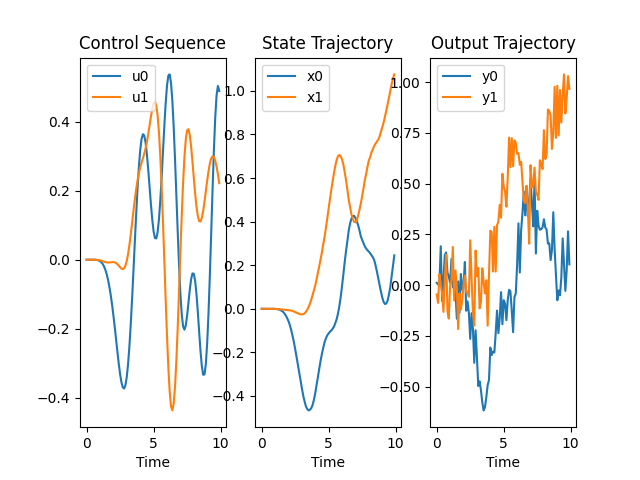

<AxesSubplot:title={'center':'Output Trajectory'}, xlabel='Time'>

In [7]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3)

# generate control and plot it
si.plotu(traj, ax1)
# Generate trajectory (noisy integration of control sequence)
si.plotx(traj, ax=ax2)
# Observations (noisy gps)
si.ploty(traj, ax=ax3)

### We now filter the trajectory using a Kalman Filter, first with gps observations

In [12]:
A = np.eye(2)
B = dt * np.eye(2)
C = np.eye(2)
Q = dt * np.eye(2) * u_std
R = np.diag([y_std, y_std])

kf = KalmanFilter(A,B,C,Q,R)

In [13]:
preds = np.zeros((len(t), 2))
preds[0] = x0
x = x0; P = np.eye(2)
for i in range(1, len(t)):
    x, P = kf.predict(x, P, u.y.T[i])
    preds[i] = x

In [14]:
# KF with pred + update
P0 = np.eye(2)
Ps = np.zeros((N,2,2))
Ps[0] = P0
filtered = np.zeros((N,2))
filtered[0] = x0
x = x0; P = P0;
for i in range(1,len(t)):
    x, P = kf.predict(x, P, np.zeros(2))
    x, P = kf.update(x, P, traj.y.T[i])
    filtered[i] = x
    Ps[i] = P

In [15]:
from ipywidgets import interact
@interact(ground_truth=True, observations=True, pred=False, pred_and_update=True)
def f(ground_truth, observations, pred, pred_and_update):
    fig, ax = plt.subplots()
    if ground_truth:
        si.plot_phase(traj, label="ground truth", ax=ax, color="black")
    if observations:
        plt.scatter(*traj.y, label="observations", color="black", alpha=0.5)
    if pred:
        plt.plot(*preds.T, label="KF pred", color="blue")
    if pred_and_update:
        kf.plot(filtered, Ps, ax=ax, label="pred+update", color="orange")
    plt.legend()

interactive(children=(Checkbox(value=True, description='ground_truth'), Checkbox(value=True, description='obse…